# Классификация комментариев пользователей интернет-магазина

### Введение

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  
В нашем распоряжении набор данных с разметкой о токсичности правок.

Задача - обучить модель классифицировать комментарии на позитивные и негативные. Метрика качества - *F1* - должна быть не меньше 0.75. 

#### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

#### План работы

1. Загрузка и подготовка данных.
2. Обучение разных моделей. 
3. Выводы.




### 1. Загрузка и подготовка данных.

### 1.1. Загрузка и обзор данных.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import joblib

In [2]:
# загрузка данных
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Произведем лемматизацию, очистим тексты от ненужных символов, переведем тексты в стандартный для Python формат - кодировку Unicode.

### 1.2. Подготовка данных.

In [6]:
# импорт библиотеки NLTK (Natural Language Toolkit), модуля 're' (regular expressions), инициализация лемматизатора
import nltk
import re
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [7]:
# функция удаления ненужных символов и лемматизации
def pre_process(text):
    text1 = re.sub(r'[^a-zA-Z]',' ', text) # замена ненужных символов на пробелы
    tokens = nltk.word_tokenize(text1) # токенизация - разбивка текста на отдельные слова
    text2 = ' '.join([lemmatizer.lemmatize(w) for w in tokens]) # лемматизация токенов и объединение в строку
    return text2

In [8]:
%%time
# применим функцию удаления ненужных символов и лемматизации к столбцу 'text'
df['text']=df['text'].apply(pre_process)

Wall time: 4min 29s


In [9]:
# переведем столбец'text' в нижний регистр:
df['text'] = df['text'].str.lower()

In [10]:
# переведем тексты в кодировку Unicode
df['text'] = df['text'].astype('U')

In [11]:
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestion on impro...,0
4,you sir are my hero any chance you remember wh...,0


In [12]:
# еще раз проверим на наличие дупликатов: они могли появиться в процессе предобработки
df.duplicated().sum()

1296

In [13]:
# удалим дупликаты
df = df.drop_duplicates().reset_index(drop=True)

Данные готовы к векторизации и работе с моделями.

### 1.3. Анализ количества токсичных комментариев.

Сравним количество позитивных и негативных (токсичных) комментариев графически и вычислим долю каждого типа комментариев.

In [14]:
import matplotlib.pyplot as plt

In [15]:
# количество негативных отзывов
neg = df['toxic'].sum()
# количество позитивных отзывов
pos = len(df)-neg

In [16]:
# подготовка к построению графика 
picture = pd.DataFrame(data = [pos, neg], columns = ['qty'], index = ['positive', 'negative'])

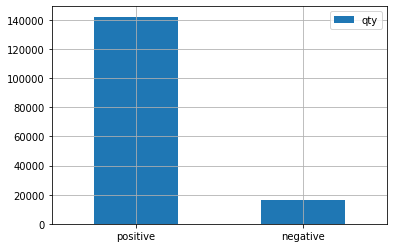

In [17]:
picture.plot.bar(grid=True, rot=0)

In [18]:
print('Доля позитивных отзывов, %:', round(pos/len(df)*100,1))
print('Доля негативных отзывов, %:', round(neg/len(df)*100,1))

Доля позитивных отзывов, %: 89.8
Доля негативных отзывов, %: 10.2


### 2. Обучение моделей и тестирование.

Рассмотрим работу моделей "мешок слов", "N-граммы" и "TF-IDF" на основе алгоритма логистической регрессии, дерева решений и случайного леса.   
Чтобы сделать код короче, одновременно с расчетом значения метрики на валидационной выборке рассчитаем ее значение и на тестовой выборке.

In [19]:
# импорт функций
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [20]:
# создадим корпус (список текстов)
corpus = df['text'].values

In [21]:
# выделение тестовой выборки
corpus_1, corpus_test, target_1, target_test = train_test_split(corpus, df['toxic'], test_size=0.2, random_state=12345)

In [22]:
# выделение обучающей и валидационной выборок
corpus_train, corpus_valid, target_train, target_valid = train_test_split(corpus_1, target_1, test_size=0.25, random_state=12345)

In [23]:
# подготовим пакет 'stopwords' для удаления слов без смысловой нагрузки.
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [24]:
# заготовка таблицы результата
columns = ['method', 'model', 'max_depth', 'n_estimators', 'f1_score_valid', 'f1_score_test']
data = []

In [25]:
# функция обучения и работы модели с расчетом значения метрики
def score (model, features_train, target_train, features_valid, features_test, target_valid, target_test):
    # обучение модели
    model.fit(features_train, target_train)
    # работа модели на валидационной выборке
    pred_valid = model.predict(features_valid)
    # работа модели на тестовой выборке
    pred_test = model.predict(features_test)
    # значение метрики на валидации
    f1_score_valid = f1_score(target_valid, pred_valid)
    # значение метрики на тесте
    f1_score_test = f1_score(target_test, pred_test)
    return f1_score_valid, f1_score_test 

 В цикле ниже рассмотрим только модель логистической регрессии. Дерево решений и случайный лес при подборе методов и параметров работают неприемлимо долго (с их участием цикл длится 1 час 50 мин), поэтому будут рассмотрены отдельно с уже подобранными параметрами.

При работе с логистической регрессией пришлось изменить параметр 'max_iter': при дефолтном значении max_iter = 100 выходило предупреждение ConvergenceWarning и рекомендация увеличить число итераций.

In [26]:
%%time

# "мешок слов", биграммы и tf_idf для логистической регрессии

for method in ['bag', 'bi_gramm', 'tf_idf']:
    # инициализация счетчика в зависимости от метода
    if method == 'bag':
        count = CountVectorizer(stop_words=stop_words)
    if method == 'bi_gramm':
        count = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words)
    if method == 'tf_idf':
        count = TfidfVectorizer(stop_words=stop_words)
    # настройка счетчика
    count.fit(corpus_train)
    # трансформация признаков
    features_train = count.transform(corpus_train)
    features_valid = count.transform(corpus_valid)
    features_test = count.transform(corpus_test)
    # инициализация модели
    model = LogisticRegression(class_weight='balanced', random_state=12345, solver='lbfgs', max_iter = 800)
    # функция обучения и работы модели с расчетом значения метрики
    f1_score_valid, f1_score_test = score (model, features_train, target_train, features_valid, features_test, target_valid, target_test)
    # внесение результата в таблицу сравнения 
    data.append([method, 'logistic_regression', np.nan, np.nan, f1_score_valid, f1_score_test])

Wall time: 6min 38s


Ниже приведен пример работы дерева решений по методу 'tf_idf' с параметром max_depth = 15. При этих параметрах дерево решений показало лучшие результаты f1. Фактически были рассмотрены также методы "мешок слов" и биграммы при max_depth = (5, 10, 15).

In [27]:
%%time

# 'tf_idf' для дерева решений

# инициализация счетчика
count = TfidfVectorizer(stop_words=stop_words)
# настройка счетчика
count.fit(corpus_train)
# трансформация признаков
features_train = count.transform(corpus_train)
features_valid = count.transform(corpus_valid)
features_test = count.transform(corpus_test)
# инициализация модели
model = DecisionTreeClassifier(max_depth = 15, random_state = 12345)
# функция обучения и работы модели с расчетом значения метрики
f1_score_valid, f1_score_test = score (model, features_train, target_train, features_valid, features_test, target_valid, target_test)
# внесение результата в таблицу сравнения
data.append(['tf_idf', 'decision_tree', 15, np.nan, f1_score_valid, f1_score_test])

Wall time: 57.1 s


Для случайного леса пришлось применить большие (=200...800) значения 'max_depth': при значениях менее 15 появлялось предупреждение, что f1 не может быть расчитано в силу отсутствия предсказанных значений, а при 'max_depth' менее 50 значение f1 оказывалось близко к нулю. При этом значение параметра 'n_estimators' (рассмотрено 5, 15, 30) на результат влияло несущественно. Но модель случайного леса нормально работала при 'max_depth = None' (значение по умолчанию). Это значение и было оставлено в итоговой версии кода.  
Для случайного леса оставили только метод "мешок слов", т.к. попытка включения в цикл методов биграмм и tf_idf привела к неприемлимо долгой работе кода при результате очень близком к результату "мешка слов" (tf_idf) либо гораздо худшем (биграммы).

In [28]:
%%time

# "мешок слов" для случайного леса

# инициализация счетчика уникальных слов
count = CountVectorizer(stop_words=stop_words)
# настройка счетчика
count.fit(corpus_train)
# трансформация признаков
features_train = count.transform(corpus_train)
features_valid = count.transform(corpus_valid)
features_test = count.transform(corpus_test)
# инициализация модели
model = RandomForestClassifier(n_estimators = 5, random_state = 12345)
# функция обучения и работы модели с расчетом значения метрики
f1_score_valid, f1_score_test = score (model, features_train, target_train, features_valid, features_test, target_valid, target_test)
# внесение результата в таблицу сравнения
data.append(['bag', 'random_forest', np.nan, 5, f1_score_valid, f1_score_test])

Wall time: 1min 44s


In [29]:
# таблица результата
summary = pd.DataFrame(data=data, columns=columns).sort_values(by='f1_score_valid', ascending=False).reset_index(drop=True)
summary

,method,model,max_depth,n_estimators,f1_score_valid,f1_score_test
0,bag,logistic_regression,NaN,NaN,0.756416,0.754557
1,tf_idf,logistic_regression,NaN,NaN,0.743808,0.747860
2,bag,random_forest,NaN,5.0,0.656536,0.678073
3,tf_idf,decision_tree,15.0,NaN,0.611288,0.628913
4,bi_gramm,logistic_regression,NaN,NaN,0.496815,0.496858


### 3. Выводы

Была проделана следующая работа:  
После загрузки данных была произведена леммитизация текстов, ненужные символы были удалены. Для лемматизации была использована библиотека NLTK (Natural Language Toolkit). Тексты были переведены в кодировку Unicode.  
Векторизацию текстов произвели тремя способами - методом "мешок слов", биграмма и TD-IDF. Для всех трех методов при построении модели предсказания попробовали алгоритмы логистической регрессии, дерева решений и случайного леса.  
Лучший результат показал метод "мешок слов" для логистической регрессии - значение метрики F1 на тестовой выборке удовлетворяет поставленному условию F1 >= 0.75.